    Loan_ID  Gender Married Dependents     Education Self_Employed  \
0  LP002305  Female      No          0      Graduate            No   
1  LP001715    Male     Yes         3+  Not Graduate           Yes   
2  LP002086  Female     Yes          0      Graduate            No   
3  LP001136    Male     Yes          0  Not Graduate           Yes   
4  LP002529    Male     Yes          2      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             4547                0.0       115.0             360.0   
1             5703                0.0       130.0             360.0   
2             4333             2451.0       110.0             360.0   
3             4695                0.0        96.0             360.0   
4             6700             1750.0       230.0             300.0   

   Credit_History Property_Area  Loan_Status  
0             1.0     Semiurban            1  
1             1.0         Rural            1  
2          

C:\Users\user\AppData\Local\Temp\ipykernel_508\1003649150.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:00:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.9}


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:00:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Test Accuracy: 0.8709677419354839
Training Random Forest...
Random Forest Test Accuracy: 0.8387096774193549
Training SVM...
SVM Test Accuracy: 0.7849462365591398
Best model (XGBClassifier) saved with accuracy: 0.8709677419354839

Accuracy Comparison:
XGBoost: 0.8710
Random Forest: 0.8387
SVM: 0.7849


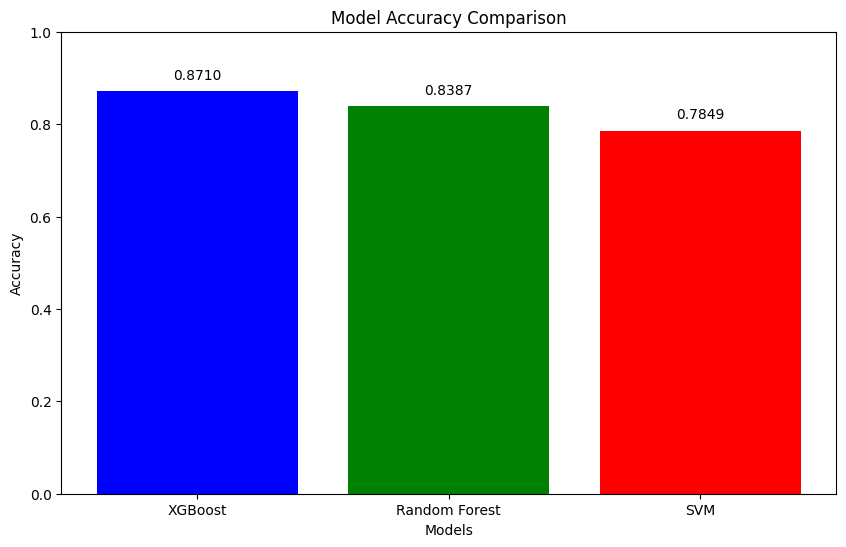

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('loan_train.csv')

# Display the first few rows of the dataset
print(df.head())

# Data Preprocessing
# Handle missing values (if any)
df.fillna(method='ffill', inplace=True)

# Convert categorical variables to numerical using Label Encoding
label_encoders = {}
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature Engineering: Create new features
df['Income_to_Loan_Ratio'] = df['ApplicantIncome'] / df['LoanAmount']
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Drop irrelevant features
df.drop(['Loan_ID'], axis=1, inplace=True)

# Separate features and target variable
X = df.drop(['Loan_Status'], axis=1)
y = df['Loan_Status']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Define models
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42, probability=True)
}

# Dictionary to store model accuracies
accuracies = {}

# Train and evaluate each model
best_model = None
best_accuracy = 0

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Hyperparameter Tuning for XGBoost
    if model_name == "XGBoost":
        param_grid = {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'gamma': [0, 0.1, 0.2],
            'reg_alpha': [0, 0.1, 0.5],
            'reg_lambda': [0, 0.1, 0.5]
        }
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
        grid_search.fit(X_train_balanced, y_train_balanced)
        model = grid_search.best_estimator_
        print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    
    # Train the model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Evaluate on the test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[model_name] = accuracy
    print(f"{model_name} Test Accuracy: {accuracy}")
    
    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Save the best model
if best_model is not None:
    joblib.dump(best_model, 'xgboostModel.pkl')
    print(f"Best model ({best_model.__class__.__name__}) saved with accuracy: {best_accuracy}")

# Print accuracy comparison
print("\nAccuracy Comparison:")
for model_name, accuracy in accuracies.items():
    print(f"{model_name}: {accuracy:.4f}")

# Plot accuracy comparison bar chart
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')
plt.show()